In [2]:
%cd /home/hotson/kaggle_work/csiro-biomass/

/home/hotson/kaggle_work/csiro-biomass


# Importing Modules

In [37]:
from scripts.models import dinov3_multi_reg
from torch.utils.data import dataloader, Dataset
from warnings import filterwarnings
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn.functional as F
import numpy as np
import albumentations as A
from pathlib import Path
from scripts.train import competition_metric
from matplotlib import pyplot as plt
from scripts.utils import set_seed, Config as train_config
from PIL import Image
import seaborn as sns
from sklearn.metrics import r2_score

filterwarnings("ignore")

# Config

In [22]:
class Config:
    model_path: Path = Path("/home/hotson/kaggle_work/csiro-biomass/mlruns/597322682940838758/ce00b1514eb347d79e8c6af67008fb68/artifacts/fold_0_best/dinov3_reg_fold0.pt")
    device: torch.device = train_config.DEVICE
    model_id: str = "facebook/dinov3-vith16plus-pretrain-lvd1689m"
    patch_size: int = 16
    val_df_path: Path = Path("/home/hotson/kaggle_work/csiro-biomass/exps/splits/csiro_no_folds_75_25_split/val_fold0.csv")
    img_size: int = 512
    img_dir: Path = Path("/home/hotson/kaggle_work/csiro-biomass/train")

set_seed(train_config.SEED)

# Inference DataLoader

In [34]:
class InferenceDataset(Dataset):
    def __init__(self, df: pd.DataFrame, img_size: int):
        self.df = df.reset_index(drop=True)
        self.img_size = img_size
        self.target5_cols = ["Dry_Green_g", "Dry_Dead_g", "Dry_Clover_g", "GDM_g", "Dry_Total_g"]
        self.aug = A.Compose(
            [
                A.Resize(self.img_size, self.img_size * 2),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                A.pytorch.ToTensorV2(),
            ]
        )
    
    def __len__(self):
        return len(self.df)
    
    def split_left_right_method(self, img_t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        _, _, w = img_t.shape
        mid = w // 2
        left = img_t[:, :, :mid]
        right = img_t[:, :, mid:]
        return left, right

    def ensure_square(self, t:torch.Tensor) -> torch.Tensor:
        if t.shape[1] == self.img_size and t.shape[2] == self.img_size:
            return t
        
        t = t.unsqueeze(0) # (1, 3, H, W)
        t = F.interpolate(input = t, size = (self.img_size, self.img_size), mode = "bilinear", align_corners=False)
        return t.squeeze(0)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        targets_5 = torch.from_numpy(row[self.target5_cols].to_numpy(dtype = "float32"))

        img_path = str(row['image_path'])

        with open(img_path, 'rb') as f:
            image = Image.open(f).convert("RGB")
        
        image = np.array(image)
        image_t = self.aug(image = image)["image"]

        left_t, right_t = self.split_left_right_method(image_t)

        left_t = self.ensure_square(left_t)
        right_t = self.ensure_square(right_t)

        image_id = row['image_id']
        return image_id, left_t, right_t, targets_5

# Loading Model

In [31]:
model = dinov3_multi_reg.Dinov3MultiReg(dinov3_multi_reg.Dinov3Config(model_id=Config.model_id, patch_size=Config.patch_size))
ckpt = torch.load(Config.model_path, map_location = Config.device)

state = ckpt["model_state"] if isinstance(ckpt, dict) and "model_state" in ckpt else ckpt
model.load_state_dict(state, strict=True)

model.to(Config.device)
model.eval()

print("Loaded model: ", model.__class__.__name__)

[WARN] HF load failed for facebook/dinov3-vith16plus-pretrain-lvd1689m (OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/facebook/dinov3-vith16plus-pretrain-lvd1689m.
401 Client Error. (Request ID: Root=1-696e4742-6d7c3e322ff64a277c525f6a;77532d96-70c9-417a-ba6b-32694df50ccb)

Cannot access gated repo for url https://huggingface.co/facebook/dinov3-vith16plus-pretrain-lvd1689m/resolve/main/config.json.
Access to model facebook/dinov3-vith16plus-pretrain-lvd1689m is restricted. You must have access to it and be authenticated to access it. Please log in.)
[WARN] Falling back to timm backbone: vit_huge_plus_patch16_dinov3.lvd1689m
Encoder trainable params: 0 | backend: timm | D: 1280
Loaded model:  Dinov3MultiReg


# Loading inference data

In [35]:
val_df = pd.read_csv(Config.val_df_path)

val_ds = InferenceDataset(df = val_df, img_size = Config.img_size)
val_dataloader = dataloader.DataLoader(
    dataset = val_ds,
    batch_size = 4,
    shuffle = False,
    num_workers = 4,
    pin_memory=True,
    drop_last=False
)

all_preds = []
with torch.no_grad():
    for (img_ids, img_left_t, img_right_t, gt_t) in tqdm(val_dataloader, desc = "inference", leave = False):
        img_left_t = img_left_t.to(Config.device)
        img_right_t = img_right_t.to(Config.device)

        preds = model((img_left_t, img_right_t))

        for img_id, pred in zip(img_ids, preds.cpu().numpy()):
            all_preds.append({
                "image_id": img_id,
                "Dry_Green_g": pred[0],
                "Dry_Dead_g": pred[1],
                "Dry_Clover_g": pred[2],
                "GDM_g": pred[3],
                "Dry_Total_g": pred[4],
            })

preds_df = pd.DataFrame(all_preds)
preds_df

,image_id,Dry_Green_g,Dry_Dead_g,Dry_Clover_g,GDM_g,Dry_Total_g
0,ID1025234388,3.211274,2.471805,3.638535,6.849809,9.321613
1,ID1051144034,10.800687,9.764881,43.780807,54.581493,64.346375
2,ID1108283583,27.897005,6.363970,12.055113,39.952118,46.316090
3,ID1113329413,3.930409,11.369268,31.471098,35.401508,46.770775
4,ID112966473,16.577744,1.998915,5.478852,22.056595,24.055510
...,...,...,...,...,...,...
61,ID7850481,6.420535,1.229732,19.015184,25.435719,26.665451
62,ID797502182,7.636997,4.663181,1.053370,8.690367,13.353548
63,ID799079114,14.460557,14.522336,0.569305,15.029862,29.552198
64,ID875119737,17.676584,2.543164,3.192721,20.869305,23.412468


# Model Performance

In [36]:
merged_df = val_df.merge(
    preds_df,
    on = "image_id",
    how = "inner",
    suffixes=("_gt", "_pred")
)
merged_df

,image_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g_gt,Dry_Dead_g_gt,Dry_Green_g_gt,Dry_Total_g_gt,GDM_g_gt,env_group,strata,fold,Dry_Green_g_pred,Dry_Dead_g_pred,Dry_Clover_g_pred,GDM_g_pred,Dry_Total_g_pred
0,ID1025234388,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.38,1.0,6.0500,0.0000,0.0000,6.0500,6.0500,WA_2015/9/1,0,0,3.211274,2.471805,3.638535,6.849809,9.321613
1,ID1051144034,train/ID1051144034.jpg,2015/9/1,WA,SubcloverLosa,0.80,1.0,55.3200,0.0000,0.0000,55.3200,55.3200,WA_2015/9/1,40,0,10.800687,9.764881,43.780807,54.581493,64.346375
2,ID1108283583,train/ID1108283583.jpg,2015/8/19,Vic,Phalaris_Ryegrass_Clover,0.83,5.5,5.7730,7.2162,40.4108,53.4000,46.1838,Vic_2015/8/19,42,0,27.897005,6.363970,12.055113,39.952118,46.316090
3,ID1113329413,train/ID1113329413.jpg,2015/6/29,Tas,WhiteClover,0.72,3.0,20.6523,21.1112,1.3768,43.1403,22.0291,Tas_2015/6/29,30,0,3.930409,11.369268,31.471098,35.401508,46.770775
4,ID112966473,train/ID112966473.jpg,2015/8/14,Vic,Ryegrass_Clover,0.74,3.0,11.2000,2.8000,19.6000,33.6000,30.8000,Vic_2015/8/14,21,0,16.577744,1.998915,5.478852,22.056595,24.055510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,ID7850481,train/ID7850481.jpg,2015/9/1,WA,SubcloverLosa,0.69,1.0,19.5700,0.0000,0.0000,19.5700,19.5700,WA_2015/9/1,0,0,6.420535,1.229732,19.015184,25.435719,26.665451
62,ID797502182,train/ID797502182.jpg,2015/7/1,Tas,Ryegrass,0.43,3.0,0.0000,12.6079,6.9746,19.5825,6.9746,Tas_2015/7/1,1,0,7.636997,4.663181,1.053370,8.690367,13.353548
63,ID799079114,train/ID799079114.jpg,2015/7/1,Tas,Ryegrass,0.53,4.0,0.0000,19.7501,8.0022,27.7523,8.0022,Tas_2015/7/1,10,0,14.460557,14.522336,0.569305,15.029862,29.552198
64,ID875119737,train/ID875119737.jpg,2015/8/14,Vic,Ryegrass_Clover,0.72,4.0,5.8000,5.8000,23.2000,34.8000,29.0000,Vic_2015/8/14,22,0,17.676584,2.543164,3.192721,20.869305,23.412468


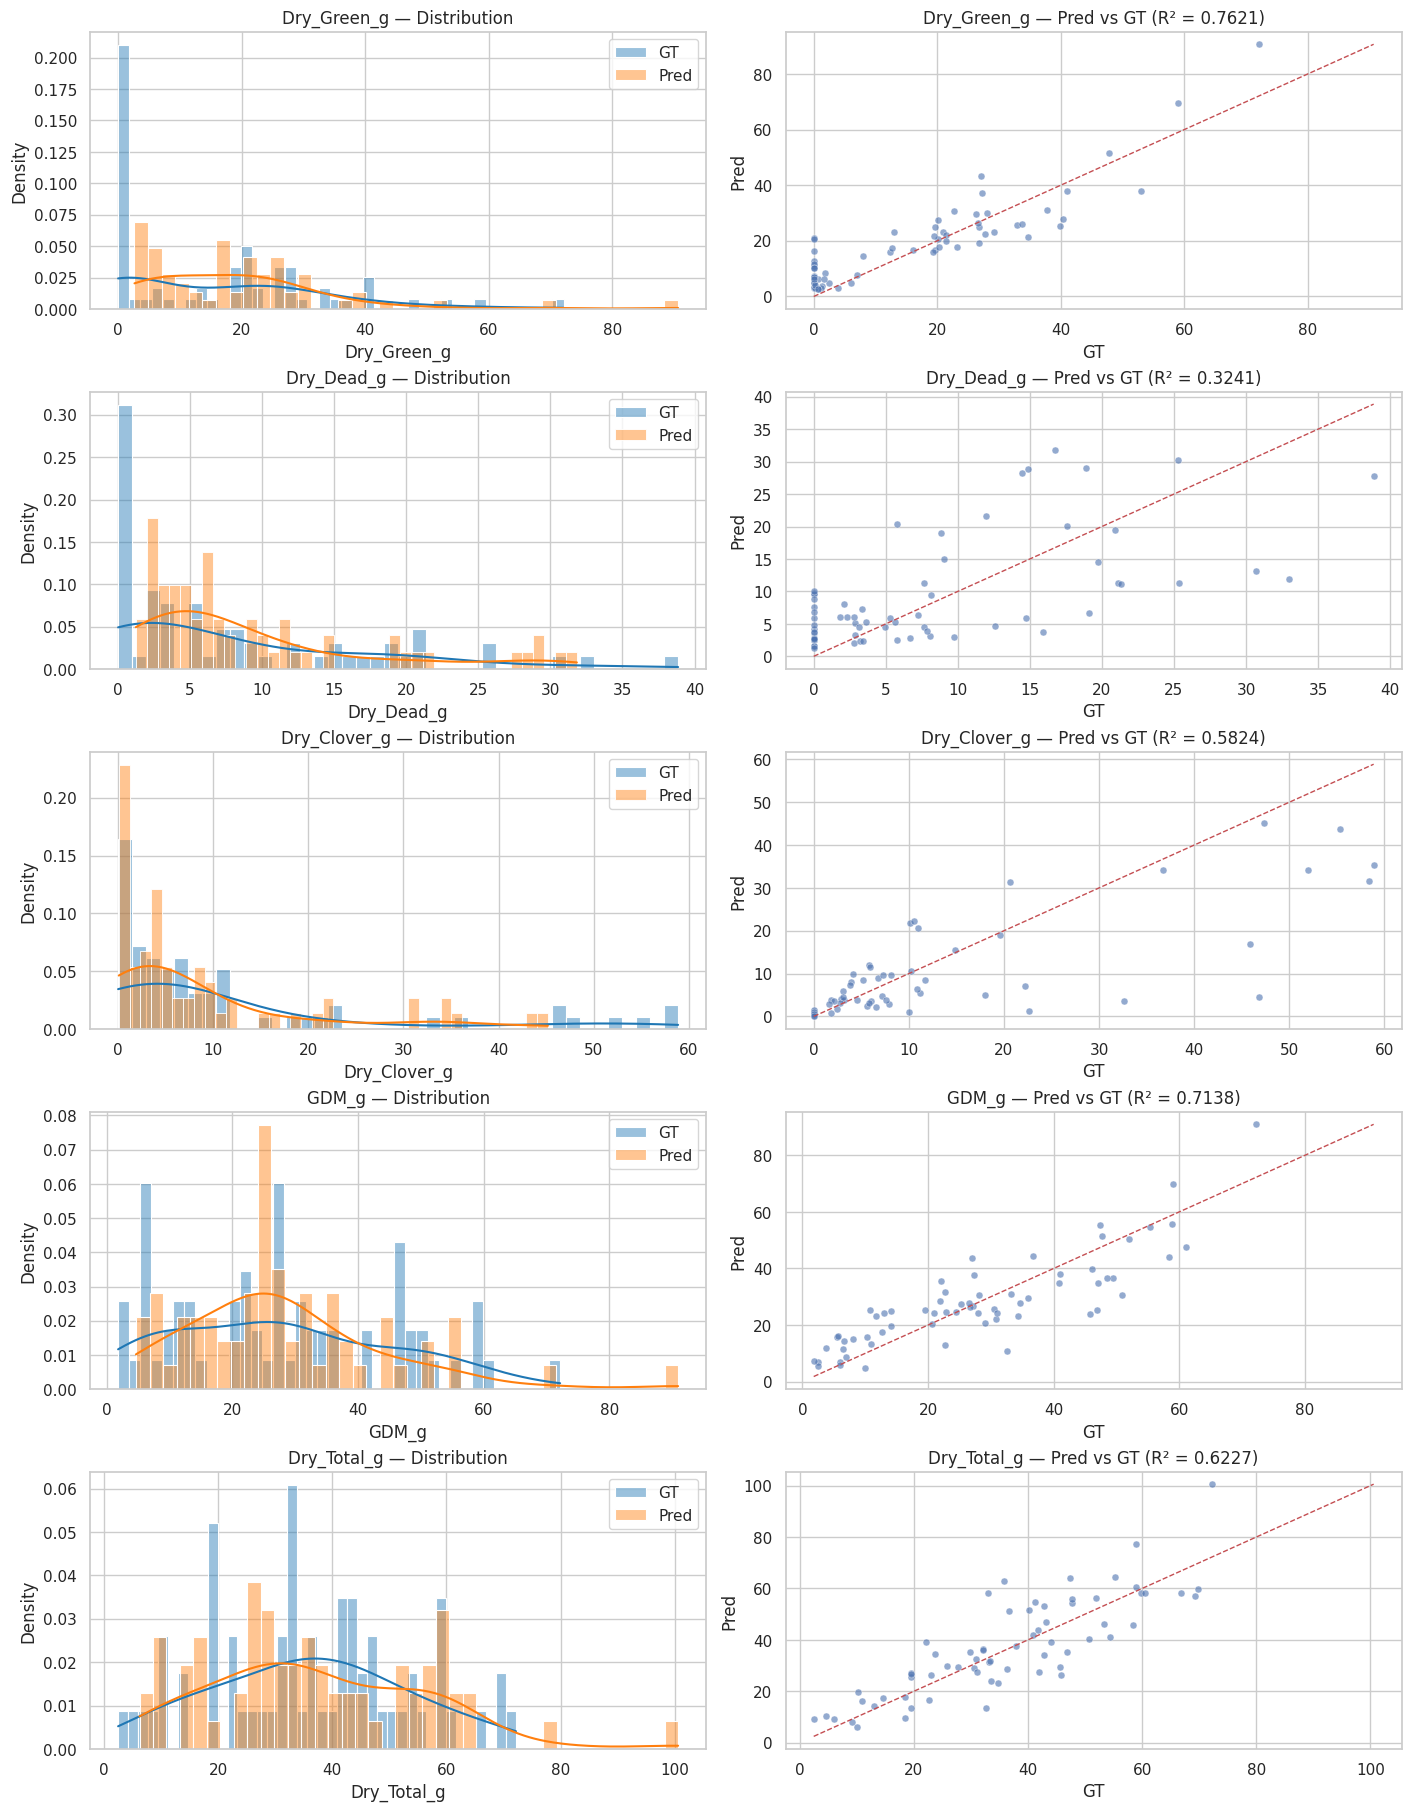

In [40]:
sns.set_theme(style="whitegrid")  # optional
targets = ["Dry_Green_g", "Dry_Dead_g", "Dry_Clover_g", "GDM_g", "Dry_Total_g"]
fig, axes = plt.subplots(
    nrows=5,
    ncols=2,
    figsize=(14, 18),
    constrained_layout=True
)

for i, t in enumerate(targets):
    gt = merged_df[f"{t}_gt"].astype(float).to_numpy()
    pred = merged_df[f"{t}_pred"].astype(float).to_numpy()

    # -----------------------------
    # Left: Histogram (GT vs Pred)
    # -----------------------------
    ax_hist = axes[i, 0]
    sns.histplot(gt, bins=40, stat="density", kde=True,
                 color="tab:blue", alpha=0.45, label="GT", ax=ax_hist)
    sns.histplot(pred, bins=40, stat="density", kde=True,
                 color="tab:orange", alpha=0.45, label="Pred", ax=ax_hist)

    ax_hist.set_title(f"{t} — Distribution")
    ax_hist.set_xlabel(t)
    ax_hist.set_ylabel("Density")
    ax_hist.legend()

    # -----------------------------
    # Right: Scatter + R²
    # -----------------------------
    ax_scatter = axes[i, 1]
    r2 = r2_score(gt, pred)

    sns.scatterplot(x=gt, y=pred, s=25, alpha=0.6, ax=ax_scatter)

    mn = min(gt.min(), pred.min())
    mx = max(gt.max(), pred.max())
    ax_scatter.plot([mn, mx], [mn, mx], "r--", linewidth=1)

    ax_scatter.set_title(f"{t} — Pred vs GT (R² = {r2:.4f})")
    ax_scatter.set_xlabel("GT")
    ax_scatter.set_ylabel("Pred")

plt.show()
